#### Simulate the process

In [3]:
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely import geometry as geom
from scipy.ndimage import gaussian_filter

import libpysal as ps
from esda.moran import Moran

In [2]:
# parameters
random_seed = 42
grid_side_length =7

In [21]:
# First county grid dataframe

np.random.seed(random_seed)  # Set the random seed for reproducibility

num_squares = grid_side_length ** 2
df = pd.DataFrame({'Index': np.arange(num_squares)})


# Define grid size and statistical parameters
grid_size = (grid_side_length, grid_side_length)
mean, std_dev = 0.5, 0.5

# Generate initial random values
random_values = np.random.normal(mean, std_dev, grid_size) # Random values with normal distribution
# random_values =  np.random.wald(mean=mean, scale=std_dev, size=grid_size)  # Inverse Gaussian


# assign values as positive autocorrelation
values = gaussian_filter(random_values, sigma=1.5)  # Apply Gaussian smoothing for spatial correlation

# Assign values to the DataFrame
df['Value'] = values.ravel()

# Multiply values by 30 (expected value)
df['Value'] = df['Value'] * 30

# Function to calculate square coordinates
def calculate_square_coordinates(row):
    value = row['Index']
    x = value % grid_side_length
    y = value // grid_side_length
    return geom.Polygon([(x, y), (x+1, y), (x+1, y+1), (x, y+1)])

# Convert to GeoDataFrame with square geometries
df['geometry'] = df.apply(calculate_square_coordinates, axis=1)
gdf = gpd.GeoDataFrame(df, geometry='geometry')


In [22]:
gdf.tail()

,Index,Value,geometry
44,44,5.768420,"POLYGON ((2 6, 3 6, 3 7, 2 7, 2 6))"
45,45,8.146961,"POLYGON ((3 6, 4 6, 4 7, 3 7, 3 6))"
46,46,12.623551,"POLYGON ((4 6, 5 6, 5 7, 4 7, 4 6))"
47,47,16.923819,"POLYGON ((5 6, 6 6, 6 7, 5 7, 5 6))"
48,48,19.292526,"POLYGON ((6 6, 7 6, 7 7, 6 7, 6 6))"


<Axes: >

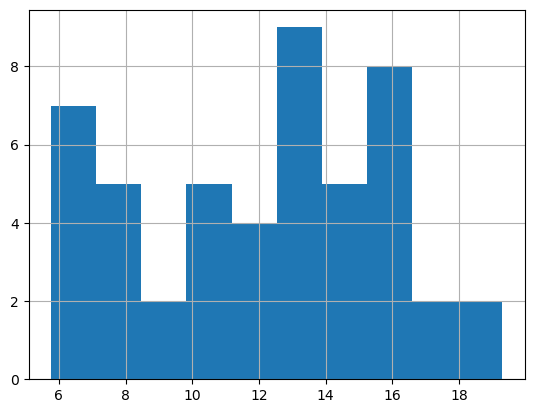

In [23]:
gdf['Value'].hist()

<Axes: >

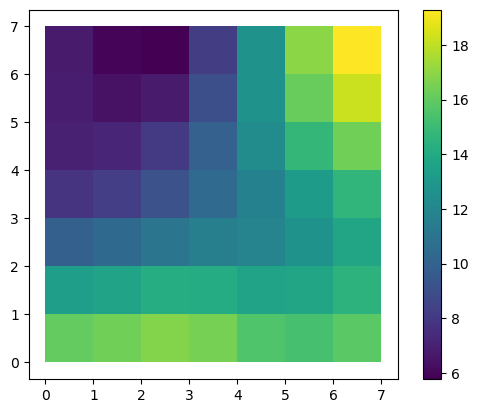

In [24]:
# plot the grid
gdf.plot(column='Value', cmap='viridis', legend=True)


In [27]:
gdf.head()

,Index,Value,geometry
0,0,16.056498,"POLYGON ((0 0, 1 0, 1 1, 0 1, 0 0))"
1,1,16.371808,"POLYGON ((1 0, 2 0, 2 1, 1 1, 1 0))"
2,2,16.780932,"POLYGON ((2 0, 3 0, 3 1, 2 1, 2 0))"
3,3,16.473685,"POLYGON ((3 0, 4 0, 4 1, 3 1, 3 0))"
4,4,15.552689,"POLYGON ((4 0, 5 0, 5 1, 4 1, 4 0))"


In [53]:
# lets create the census tracts

census_count_values = [9,16,25,49]

# Add a random seed for reproducibility
np.random.seed(random_seed)

for row in gdf.itertuples():

    parent_county_index = row[1]
    parent_county_rate = row[2]
    
    # Create a random number of census tracts from the census_count_values
    num_tracts = np.random.choice(census_count_values)

    # print(num_tracts)

    # dividethe parent county rate into the number of tracts
    tract_rates = np.random.dirichlet(np.ones(num_tracts)) * parent_county_rate

    num_squares_tracts = num_tracts
    df = pd.DataFrame({'Index': np.arange(num_squares_tracts)})

    # assign values as positive autocorrelation
    values = gaussian_filter(tract_rates, sigma=1.5)  # Apply Gaussian smoothing for spatial correlation

    # Assign values to the DataFrame
    df['Value'] = values.ravel()

    census_grid_side_length = int(np.sqrt(num_squares_tracts))

    # Function to calculate square coordinates
    def calculate_square_coordinates(row):
        value = row['Index']
        x = value % census_grid_side_length
        y = value // census_grid_side_length
        return geom.Polygon([(x, y), (x+1, y), (x+1, y+1), (x, y+1)])
    
    # Convert to GeoDataFrame with square geometries
    df['geometry'] = df.apply(calculate_square_coordinates, axis=1)
    gdf_single_county = gpd.GeoDataFrame(df, geometry='geometry')

    print(gdf_single_county.head())

    # gdf_single_county.plot(column='Value', cmap='viridis', legend=True)

    # add county id
    gdf_single_county['county_id'] = parent_county_index


    print(tract_rates.sum())    
    print(gdf_single_county['Value'].sum())







    break

   Index     Value                             geometry
0      0  0.750940  POLYGON ((0 0, 1 0, 1 1, 0 1, 0 0))
1      1  0.708641  POLYGON ((1 0, 2 0, 2 1, 1 1, 1 0))
2      2  0.650840  POLYGON ((2 0, 3 0, 3 1, 2 1, 2 0))
3      3  0.562453  POLYGON ((3 0, 4 0, 4 1, 3 1, 3 0))
4      4  0.442221  POLYGON ((4 0, 5 0, 5 1, 4 1, 4 0))
16.05649762975283
16.05649762975283


In [61]:
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely import geometry as geom
from scipy.ndimage import gaussian_filter

# Example: assume gdf is your counties GeoDataFrame, with columns for county id and county rate.
# Also assume random_seed is defined (e.g., random_seed = 42)
random_seed = 42

# The possible numbers of census tracts per county.
census_count_values = [9, 16, 25, 49]

# Set seed for reproducibility
np.random.seed(random_seed)

# Create an empty list to store each county's census tract GeoDataFrame
county_gdf_list = []

for row in gdf.itertuples():
    parent_county_index = row[1]   # assuming first column is county id
    parent_county_rate = row[2]    # assuming second column is the rate value
    
    # Randomly choose the number of tracts for this county
    num_tracts = np.random.choice(census_count_values)
    print(num_tracts)

    # Divide the parent's county rate into tract rates using a Dirichlet distribution
    tract_rates = np.random.dirichlet(np.ones(num_tracts)) * parent_county_rate

    # Create a DataFrame to hold census tract data
    df = pd.DataFrame({'Index': np.arange(num_tracts)})

    # Apply Gaussian smoothing to introduce some positive spatial autocorrelation
    values = gaussian_filter(tract_rates, sigma=1.5)
    df['Value'] = values.ravel()

    # Determine the side length for the square grid (assumes a perfect square)
    census_grid_side_length = int(np.sqrt(num_tracts))
    
    # Function to create a square polygon for each census tract
    def calculate_square_coordinates(row):
        idx = row['Index']
        x = idx % census_grid_side_length
        y = idx // census_grid_side_length
        return geom.Polygon([(x, y), (x+1, y), (x+1, y+1), (x, y+1)])
    
    # Calculate the geometry for each tract and add it to the DataFrame
    df['geometry'] = df.apply(calculate_square_coordinates, axis=1)
    
    # Convert the DataFrame into a GeoDataFrame
    gdf_single_county = gpd.GeoDataFrame(df, geometry='geometry')
    
    # Add the parent county id to each tract
    gdf_single_county['county_id'] = parent_county_index
    
    # Optionally, print or plot a preview:
    print(gdf_single_county.head())
    print("Original tract_rates sum:", tract_rates.sum())
    print("GeoDataFrame 'Value' sum:", gdf_single_county['Value'].sum())
    
    # Append this county's GeoDataFrame to our list
    county_gdf_list.append(gdf_single_county)
    
    # Remove or comment out break so that all counties are processed
    # break

# Combine all county census tract GeoDataFrames into one final GeoDataFrame
final_gdf = pd.concat(county_gdf_list, ignore_index=True)

# Now, final_gdf contains the census tracts for all counties.
print(final_gdf.head())

# Optionally, you can plot the final result:
# final_gdf.plot(column='Value', cmap='viridis', legend=True)


25
   Index     Value                             geometry  county_id
0      0  0.750940  POLYGON ((0 0, 1 0, 1 1, 0 1, 0 0))          0
1      1  0.708641  POLYGON ((1 0, 2 0, 2 1, 1 1, 1 0))          0
2      2  0.650840  POLYGON ((2 0, 3 0, 3 1, 2 1, 2 0))          0
3      3  0.562453  POLYGON ((3 0, 4 0, 4 1, 3 1, 3 0))          0
4      4  0.442221  POLYGON ((4 0, 5 0, 5 1, 4 1, 4 0))          0
Original tract_rates sum: 16.05649762975283
GeoDataFrame 'Value' sum: 16.05649762975283
16
   Index     Value                             geometry  county_id
0      0  0.558005  POLYGON ((0 0, 1 0, 1 1, 0 1, 0 0))          1
1      1  0.614176  POLYGON ((1 0, 2 0, 2 1, 1 1, 1 0))          1
2      2  0.644077  POLYGON ((2 0, 3 0, 3 1, 2 1, 2 0))          1
3      3  0.629293  POLYGON ((3 0, 4 0, 4 1, 3 1, 3 0))          1
4      4  0.658364  POLYGON ((0 1, 1 1, 1 2, 0 2, 0 1))          1
Original tract_rates sum: 16.371807858144418
GeoDataFrame 'Value' sum: 16.37180785814442
25
   Index  

In [55]:
final_gdf.head()

,Index,Value,geometry,county_id
0,0,0.750940,"POLYGON ((0 0, 1 0, 1 1, 0 1, 0 0))",0
1,1,0.708641,"POLYGON ((1 0, 2 0, 2 1, 1 1, 1 0))",0
2,2,0.650840,"POLYGON ((2 0, 3 0, 3 1, 2 1, 2 0))",0
3,3,0.562453,"POLYGON ((3 0, 4 0, 4 1, 3 1, 3 0))",0
4,4,0.442221,"POLYGON ((4 0, 5 0, 5 1, 4 1, 4 0))",0


1424